In [1]:
import os
import argparse
import time
import datetime
from tqdm import tqdm

from munch import Munch
from torch.backends import cudnn
import torch
import torch.nn.functional as F
import numpy as np

from core.my_loader import get_train_loader, get_test_loader, InputFetcher
from core.my_solver import Solver
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader

from easydict import EasyDict as edict
from core.my_solver import compute_d_loss, compute_g_loss, moving_average, adv_loss, r1_reg, Sampler, LoaderSampler, tensor2img
from core.my_metrics import get_Z_pushed_loader_stats, calculate_cost
from core.fid_score import calculate_frechet_distance

from IPython.display import clear_output
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = "2"

def str2bool(v):
    return v.lower() in ('true')


def subdirs(dname):
    return [d for d in os.listdir(dname)
            if os.path.isdir(os.path.join(dname, d))]

lambda_id = 10.0

args = edict({
    'img_size': 64,
    'num_domains': 2,
    'latent_dim': 16,
    'hidden_dim': 512,
    'style_dim': 64, 
    'lambda_reg': 1.0,
    'lambda_cyc': 1.0,
    'lambda_sty': 1.0,
    'lambda_ds': 1.0,
    'lambda_id': lambda_id,
    'ds_iter': 100000,
    'w_hpf': -1.0,
    'randcrop_prob': 0.5,
    'total_iters': 100000,
    'resume_iter': 0,
    'batch_size': 16,
    'val_batch_size': 32,
    'lr': 1e-4,
    'f_lr': 1e-6,
    'beta1': 0.0,
    'beta2': 0.99,
    'weight_decay': 1e-4,
    'num_outs_per_domain': 10,
    'mode': 'train', 
    'num_workers': 4,
    'seed': 777,
    'train_img_dir': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train',
    'val_img_dir': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test',
    'sample_dir': 'expr/samples',
    'checkpoint_dir': f'/cache/selikhanovych/OT_competitors/stargan-v2/celeba2anime_exps/checkpoints_lambda_{lambda_id}',
    'eval_dir': 'expr/eval',
    'result_dir': 'expr/results',
    'src_dir': 'assets/representative/celeba_hq/src',
    'ref_dir': 'assets/representative/celeba_hq/ref',
    'inp_dir': 'assets/representative/custom/female',
    'out_dir': 'assets/representative/celeba_hq/src/female',
    'wing_path': 'expr/checkpoints/wing.ckpt',
    'lm_path': 'expr/checkpoints/celeba_lm_mean.npz',
    'print_every': 10,
    'sample_every': 4000,
    'save_every': 4000,
    'eval_every': 4000,
    
    'target_dataset': 'aligned_anime_faces',
    'OUTPUT_PATH': f'/cache/selikhanovych/OT_competitors/stargan-v2/celeba2anime_exps/checkpoints_lambda_{lambda_id}',
    'domains': {
        'source': 'celeba_female',
        'target': 'aligned_anime_faces',
    },
    'train_a': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train/celeba_female',
    'train_b': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train/aligned_anime_faces', 
    'test_a': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test/celeba_female',
    'test_b': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test/aligned_anime_faces',
    
    'n_epochs': 1
})

os.system(f"mkdir -p {args.OUTPUT_PATH}")
os.system(f"mkdir -p {args.checkpoint_dir}")


eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()

final_trg_index = -1
final_src_index = -1

for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            final_trg_index = trg_idx
            final_src_index = src_idx
            
print(final_trg_index, final_src_index)

cudnn.benchmark = True
torch.manual_seed(args.seed)

solver = Solver(args)

assert len(subdirs(args.train_img_dir)) == args.num_domains
assert len(subdirs(args.val_img_dir)) == args.num_domains

loaders = Munch(src=get_train_loader(root=args.train_img_dir,
                                     which='source',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                ref=get_train_loader(root=args.train_img_dir,
                                     which='reference',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                val=get_test_loader(root=args.val_img_dir,
                                    img_size=args.img_size,
                                    batch_size=args.val_batch_size,
                                    shuffle=False,
                                    num_workers=args.num_workers))

device = 'cuda'

args = solver.args
nets = solver.nets
nets_ema = solver.nets_ema
optims = solver.optims

transform = Compose([Resize((args.img_size, args.img_size)),
                     ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_a = ImageFolder(args.train_a, transform)
train_dataset_b = ImageFolder(args.train_b, transform)
test_dataset_a = ImageFolder(args.test_a, transform)
test_dataset_b = ImageFolder(args.test_b, transform)

train_loader_a = DataLoader(dataset=train_dataset_a,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

train_loader_b = DataLoader(dataset=train_dataset_b,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

test_loader_a = DataLoader(dataset=test_dataset_a,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

test_loader_b = DataLoader(dataset=test_dataset_b,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)


torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
solver.X_fixed = X_sampler.sample(10)
solver.Y_fixed = Y_sampler.sample(10)

solver.X_test_fixed = X_test_sampler.sample(10)
solver.Y_test_fixed = Y_test_sampler.sample(10)

# fetch random validation images for debugging
fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
inputs_val = next(fetcher_val)

# resume training if necessary
if args.resume_iter > 0:
    solver._load_checkpoint(args.resume_iter)

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds

eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()
num_domains = len(domains)
for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            print(f"trg_idx = {trg_idx}, trg_domain = {trg_domain}, src_domain = {src_domain}")
            break
    break
                    
print(f"trg_idx = {trg_idx}, lambda_id = {args.lambda_id}")

0 0
Number of parameters of generator: 32634883
Number of parameters of mapping_network: 2438272
Number of parameters of style_encoder: 20327808
Number of parameters of discriminator: 20263170
Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...
Preparing DataLoader to fetch source images during the training phase...
Preparing DataLoader to fetch reference images during the training phase...
Preparing DataLoader for the generation phase...
trg_idx = 0, trg_domain = aligned_anime_faces, src_domain = celeba_female
trg_idx = 0, lambda_id = 10.0


Computing l1 cost


591it [00:29, 20.21it/s]


l1 cost = 0.15074844118623856, best l1 cost = 0.15074844118623856, best iter = 96000
Computing l2 cost


591it [00:29, 20.18it/s]


l2 cost = 0.058219972960070816, best l2 cost = 0.058219972960070816, best iter = 96000
Computing FID
Calculating evaluation metrics...
Number of domains: 2
Compute FID for celeba_female2aligned_anime_faces, trg_idx = 0, trg_domain = aligned_anime_faces
Preparing DataLoader for the generation phase...


100%|██████████| 320/320 [00:39<00:00,  8.11it/s]


FID = 42.54603523962243, best FID = 41.11770475294176, best iter = 68000
FID = 42.54603523962243, best FID = 41.11770475294176, best iter = 68000
Plotting, iter = 96000
mode = train


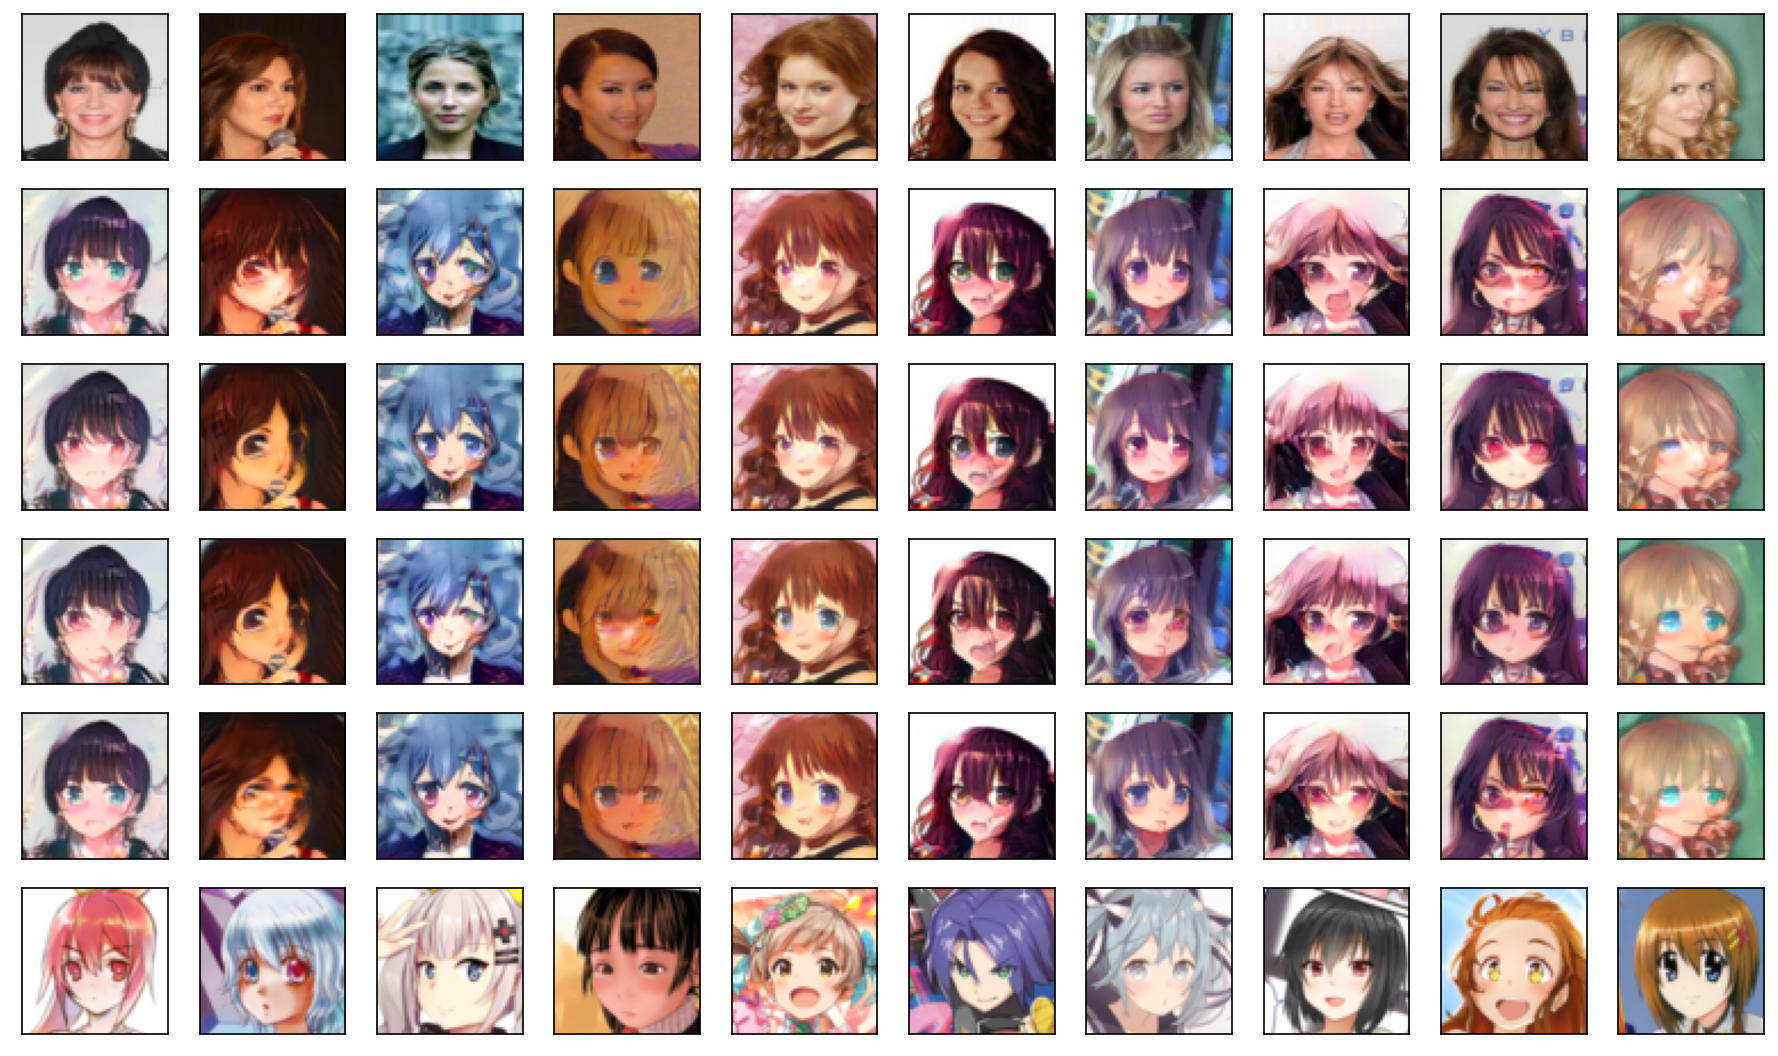

mode = test


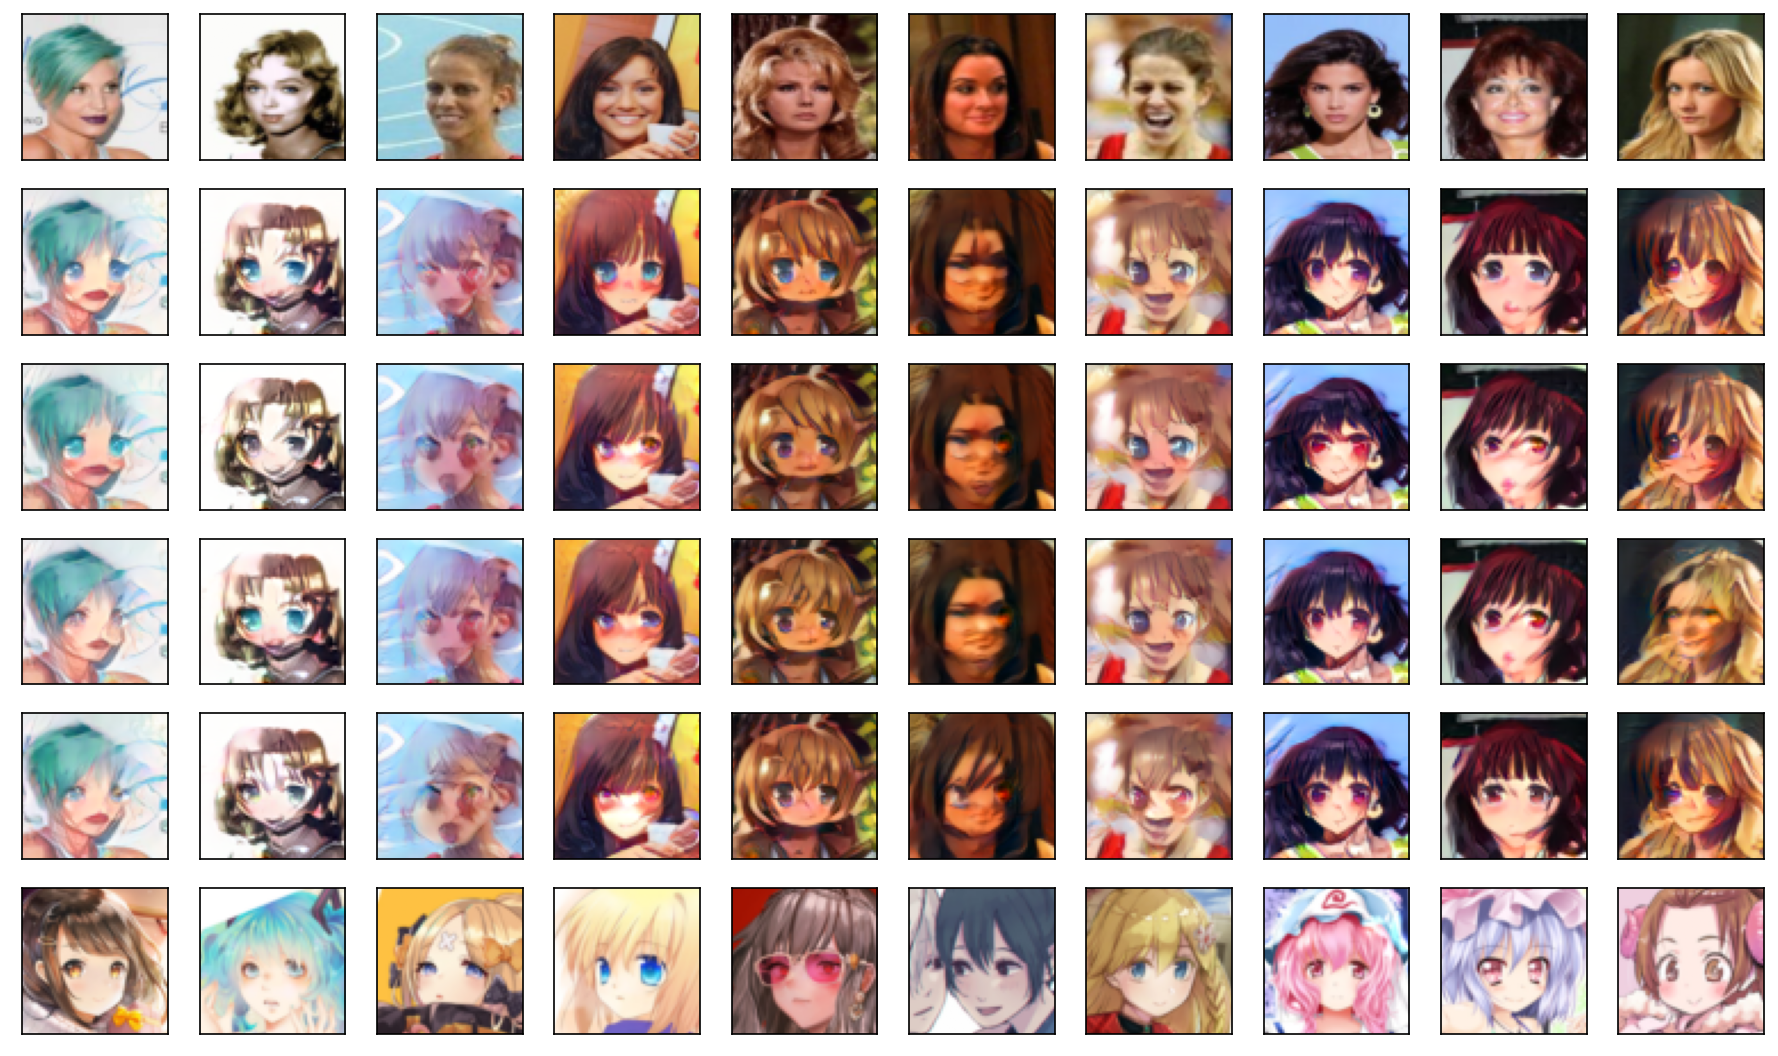

G loss = 2.162777900695801, d loss = 1.2820664644241333, lambda_id = 10.0
G loss = 2.8693325519561768, d loss = 1.1826884746551514, lambda_id = 10.0
G loss = 2.7861170768737793, d loss = 1.1286617517471313, lambda_id = 10.0
G loss = 2.665745735168457, d loss = 1.2025130987167358, lambda_id = 10.0
G loss = 2.8581061363220215, d loss = 1.2335923910140991, lambda_id = 10.0
G loss = 3.2125539779663086, d loss = 1.1542960405349731, lambda_id = 10.0
G loss = 2.4549145698547363, d loss = 1.2325491905212402, lambda_id = 10.0
G loss = 2.536315441131592, d loss = 1.234815001487732, lambda_id = 10.0
G loss = 2.39485502243042, d loss = 1.2916423082351685, lambda_id = 10.0
G loss = 3.1717658042907715, d loss = 1.2933098077774048, lambda_id = 10.0
Elapsed time [1 day, 5:54:20], Iteration [96011/100000], D/latent_real: [0.7613] D/latent_fake: [0.4491] D/latent_reg: [0.0393] D/ref_real: [0.3791] D/ref_fake: [0.8758] D/ref_reg: [0.0384] G/latent_adv: [1.6781] G/latent_sty: [0.0610] G/latent_ds: [0.0518

G loss = 2.336134195327759, d loss = 1.3010709285736084, lambda_id = 10.0
G loss = 2.280107021331787, d loss = 1.314500093460083, lambda_id = 10.0
G loss = 3.0202178955078125, d loss = 1.210736632347107, lambda_id = 10.0
G loss = 2.2912049293518066, d loss = 1.2357631921768188, lambda_id = 10.0
G loss = 2.788489580154419, d loss = 1.2444723844528198, lambda_id = 10.0
Elapsed time [1 day, 5:55:36], Iteration [96081/100000], D/latent_real: [0.6587] D/latent_fake: [0.5219] D/latent_reg: [0.0328] D/ref_real: [0.5517] D/ref_fake: [0.6561] D/ref_reg: [0.0366] G/latent_adv: [1.5127] G/latent_sty: [0.0676] G/latent_ds: [0.0654] G/latent_cyc: [0.0968] G/ref_adv: [0.8187] G/ref_sty: [0.0822] G/ref_ds: [0.0856] G/ref_cyc: [0.1491] G/lambda_ds: [0.0392]
G loss = 2.897353172302246, d loss = 1.2377618551254272, lambda_id = 10.0
G loss = 2.8406126499176025, d loss = 1.2482364177703857, lambda_id = 10.0
G loss = 3.0641305446624756, d loss = 1.18669855594635, lambda_id = 10.0
G loss = 2.583002567291259

Elapsed time [1 day, 5:56:53], Iteration [96151/100000], D/latent_real: [0.6096] D/latent_fake: [0.5563] D/latent_reg: [0.0265] D/ref_real: [0.5437] D/ref_fake: [0.7283] D/ref_reg: [0.0282] G/latent_adv: [1.3637] G/latent_sty: [0.0682] G/latent_ds: [0.0350] G/latent_cyc: [0.1041] G/ref_adv: [0.7824] G/ref_sty: [0.0870] G/ref_ds: [0.0502] G/ref_cyc: [0.1317] G/lambda_ds: [0.0385]
G loss = 2.620206594467163, d loss = 1.3232686519622803, lambda_id = 10.0
G loss = 2.5145764350891113, d loss = 1.3198262453079224, lambda_id = 10.0
G loss = 2.8178186416625977, d loss = 1.2161922454833984, lambda_id = 10.0
G loss = 2.8091440200805664, d loss = 1.277694821357727, lambda_id = 10.0
G loss = 3.3571600914001465, d loss = 1.1990103721618652, lambda_id = 10.0
G loss = 2.2106752395629883, d loss = 1.346742033958435, lambda_id = 10.0
G loss = 2.4712259769439697, d loss = 1.3108047246932983, lambda_id = 10.0
G loss = 2.5517234802246094, d loss = 1.2555168867111206, lambda_id = 10.0
G loss = 2.5359153747

G loss = 3.2307987213134766, d loss = 1.1627975702285767, lambda_id = 10.0
G loss = 2.4682674407958984, d loss = 1.3395709991455078, lambda_id = 10.0
G loss = 3.0315744876861572, d loss = 1.2542020082473755, lambda_id = 10.0
G loss = 2.9052248001098633, d loss = 1.314969539642334, lambda_id = 10.0
G loss = 2.4760618209838867, d loss = 1.2961499691009521, lambda_id = 10.0
G loss = 2.312882423400879, d loss = 1.309341549873352, lambda_id = 10.0
G loss = 2.5476365089416504, d loss = 1.2550792694091797, lambda_id = 10.0
G loss = 2.7999398708343506, d loss = 1.1776708364486694, lambda_id = 10.0
G loss = 2.3493261337280273, d loss = 1.3282428979873657, lambda_id = 10.0
G loss = 2.9130239486694336, d loss = 1.2690997123718262, lambda_id = 10.0
Elapsed time [1 day, 5:58:20], Iteration [96231/100000], D/latent_real: [0.7036] D/latent_fake: [0.4937] D/latent_reg: [0.0417] D/ref_real: [0.4830] D/ref_fake: [0.7438] D/ref_reg: [0.0423] G/latent_adv: [1.4355] G/latent_sty: [0.0680] G/latent_ds: [0.0

G loss = 2.926438808441162, d loss = 1.2428724765777588, lambda_id = 10.0
G loss = 2.646442413330078, d loss = 1.2478410005569458, lambda_id = 10.0
G loss = 2.4862682819366455, d loss = 1.2699681520462036, lambda_id = 10.0
G loss = 2.586209774017334, d loss = 1.1839213371276855, lambda_id = 10.0
G loss = 2.5142464637756348, d loss = 1.262913465499878, lambda_id = 10.0
Elapsed time [1 day, 5:59:36], Iteration [96301/100000], D/latent_real: [0.6314] D/latent_fake: [0.5915] D/latent_reg: [0.0366] D/ref_real: [0.5820] D/ref_fake: [0.6458] D/ref_reg: [0.0351] G/latent_adv: [1.3476] G/latent_sty: [0.0795] G/latent_ds: [0.0402] G/latent_cyc: [0.1047] G/ref_adv: [0.8178] G/ref_sty: [0.1183] G/ref_ds: [0.0665] G/ref_cyc: [0.1558] G/lambda_ds: [0.0370]
G loss = 3.6170928478240967, d loss = 1.3348643779754639, lambda_id = 10.0
G loss = 2.614692211151123, d loss = 1.2302632331848145, lambda_id = 10.0
G loss = 2.619577407836914, d loss = 1.2700846195220947, lambda_id = 10.0
G loss = 2.6429033279418

Elapsed time [1 day, 6:00:53], Iteration [96371/100000], D/latent_real: [0.7693] D/latent_fake: [0.5672] D/latent_reg: [0.0311] D/ref_real: [0.5902] D/ref_fake: [0.7105] D/ref_reg: [0.0275] G/latent_adv: [1.0588] G/latent_sty: [0.0595] G/latent_ds: [0.0349] G/latent_cyc: [0.0909] G/ref_adv: [0.7808] G/ref_sty: [0.0982] G/ref_ds: [0.0584] G/ref_cyc: [0.1158] G/lambda_ds: [0.0363]
G loss = 2.645984172821045, d loss = 1.1929267644882202, lambda_id = 10.0
G loss = 2.4478797912597656, d loss = 1.2446157932281494, lambda_id = 10.0
G loss = 2.5705935955047607, d loss = 1.2731925249099731, lambda_id = 10.0
G loss = 2.4585378170013428, d loss = 1.29750394821167, lambda_id = 10.0
G loss = 2.3728766441345215, d loss = 1.3387573957443237, lambda_id = 10.0
G loss = 2.744945526123047, d loss = 1.323538064956665, lambda_id = 10.0
G loss = 2.272395610809326, d loss = 1.3008103370666504, lambda_id = 10.0
G loss = 2.303189277648926, d loss = 1.254902958869934, lambda_id = 10.0
G loss = 2.065804004669189

G loss = 2.67551589012146, d loss = 1.2752468585968018, lambda_id = 10.0
G loss = 3.5244507789611816, d loss = 1.1563334465026855, lambda_id = 10.0
G loss = 2.7123208045959473, d loss = 1.3515487909317017, lambda_id = 10.0
G loss = 3.57596492767334, d loss = 1.1568068265914917, lambda_id = 10.0
G loss = 3.225882053375244, d loss = 1.2418783903121948, lambda_id = 10.0
G loss = 2.6214818954467773, d loss = 1.2711807489395142, lambda_id = 10.0
G loss = 2.5033068656921387, d loss = 1.2437646389007568, lambda_id = 10.0
G loss = 2.560870409011841, d loss = 1.2479078769683838, lambda_id = 10.0
G loss = 2.8765616416931152, d loss = 1.2440577745437622, lambda_id = 10.0
G loss = 2.5473461151123047, d loss = 1.2318450212478638, lambda_id = 10.0
Elapsed time [1 day, 6:02:20], Iteration [96451/100000], D/latent_real: [0.6083] D/latent_fake: [0.6611] D/latent_reg: [0.0350] D/ref_real: [0.6011] D/ref_fake: [0.5991] D/ref_reg: [0.0317] G/latent_adv: [1.2384] G/latent_sty: [0.0618] G/latent_ds: [0.0487

G loss = 2.8597421646118164, d loss = 1.3549189567565918, lambda_id = 10.0
G loss = 2.2297751903533936, d loss = 1.3116474151611328, lambda_id = 10.0
G loss = 2.6660749912261963, d loss = 1.1953073740005493, lambda_id = 10.0
G loss = 2.768415927886963, d loss = 1.2126891613006592, lambda_id = 10.0
G loss = 2.314934730529785, d loss = 1.336982250213623, lambda_id = 10.0
Elapsed time [1 day, 6:03:37], Iteration [96521/100000], D/latent_real: [0.8066] D/latent_fake: [0.5245] D/latent_reg: [0.0448] D/ref_real: [0.5170] D/ref_fake: [0.7865] D/ref_reg: [0.0336] G/latent_adv: [1.2097] G/latent_sty: [0.0680] G/latent_ds: [0.0420] G/latent_cyc: [0.0971] G/ref_adv: [0.7960] G/ref_sty: [0.0775] G/ref_ds: [0.0994] G/ref_cyc: [0.1339] G/lambda_ds: [0.0348]
G loss = 2.6747350692749023, d loss = 1.2185643911361694, lambda_id = 10.0
G loss = 2.499591588973999, d loss = 1.2604238986968994, lambda_id = 10.0
G loss = 2.8205103874206543, d loss = 1.2715821266174316, lambda_id = 10.0
G loss = 2.66641712188

Elapsed time [1 day, 6:04:53], Iteration [96591/100000], D/latent_real: [0.7398] D/latent_fake: [0.4579] D/latent_reg: [0.0364] D/ref_real: [0.4195] D/ref_fake: [0.7854] D/ref_reg: [0.0327] G/latent_adv: [1.5138] G/latent_sty: [0.0854] G/latent_ds: [0.0637] G/latent_cyc: [0.0989] G/ref_adv: [1.1150] G/ref_sty: [0.0898] G/ref_ds: [0.0529] G/ref_cyc: [0.1151] G/lambda_ds: [0.0341]
G loss = 2.92753529548645, d loss = 1.2054983377456665, lambda_id = 10.0
G loss = 2.6491518020629883, d loss = 1.1059439182281494, lambda_id = 10.0
G loss = 2.8375518321990967, d loss = 1.2502261400222778, lambda_id = 10.0
G loss = 2.9600329399108887, d loss = 1.2127972841262817, lambda_id = 10.0
G loss = 2.3504257202148438, d loss = 1.3759291172027588, lambda_id = 10.0
G loss = 2.408459424972534, d loss = 1.2548853158950806, lambda_id = 10.0
G loss = 2.499298334121704, d loss = 1.2749748229980469, lambda_id = 10.0
G loss = 2.823585271835327, d loss = 1.2253427505493164, lambda_id = 10.0
G loss = 2.569538593292

G loss = 2.721493721008301, d loss = 1.256178379058838, lambda_id = 10.0
G loss = 3.076589584350586, d loss = 1.1796671152114868, lambda_id = 10.0
G loss = 3.4656407833099365, d loss = 1.2028207778930664, lambda_id = 10.0
G loss = 2.4573562145233154, d loss = 1.3795409202575684, lambda_id = 10.0
G loss = 2.6437907218933105, d loss = 1.1972285509109497, lambda_id = 10.0
G loss = 2.6552958488464355, d loss = 1.2468445301055908, lambda_id = 10.0
G loss = 2.8249049186706543, d loss = 1.2345671653747559, lambda_id = 10.0
G loss = 2.596938133239746, d loss = 1.3192298412322998, lambda_id = 10.0
G loss = 2.5963025093078613, d loss = 1.2207120656967163, lambda_id = 10.0
G loss = 3.192312479019165, d loss = 1.2348850965499878, lambda_id = 10.0
Elapsed time [1 day, 6:06:20], Iteration [96671/100000], D/latent_real: [0.6558] D/latent_fake: [0.4760] D/latent_reg: [0.0293] D/ref_real: [0.4854] D/ref_fake: [0.7193] D/ref_reg: [0.0302] G/latent_adv: [1.7604] G/latent_sty: [0.0715] G/latent_ds: [0.052

G loss = 2.757845878601074, d loss = 1.1947743892669678, lambda_id = 10.0
G loss = 2.7500548362731934, d loss = 1.2358583211898804, lambda_id = 10.0
G loss = 3.0117697715759277, d loss = 1.2838855981826782, lambda_id = 10.0
G loss = 2.828962802886963, d loss = 1.2747966051101685, lambda_id = 10.0
G loss = 2.931091785430908, d loss = 1.2274378538131714, lambda_id = 10.0
Elapsed time [1 day, 6:07:36], Iteration [96741/100000], D/latent_real: [0.6459] D/latent_fake: [0.4732] D/latent_reg: [0.0311] D/ref_real: [0.4876] D/ref_fake: [0.7073] D/ref_reg: [0.0325] G/latent_adv: [1.4772] G/latent_sty: [0.0613] G/latent_ds: [0.0536] G/latent_cyc: [0.1053] G/ref_adv: [1.0335] G/ref_sty: [0.0839] G/ref_ds: [0.0665] G/ref_cyc: [0.1363] G/lambda_ds: [0.0326]
G loss = 2.610136032104492, d loss = 1.318182110786438, lambda_id = 10.0
G loss = 2.6322884559631348, d loss = 1.3068071603775024, lambda_id = 10.0
G loss = 2.6164326667785645, d loss = 1.3232824802398682, lambda_id = 10.0
G loss = 3.761514902114

Elapsed time [1 day, 6:08:53], Iteration [96811/100000], D/latent_real: [0.6926] D/latent_fake: [0.5320] D/latent_reg: [0.0389] D/ref_real: [0.4567] D/ref_fake: [0.7260] D/ref_reg: [0.0355] G/latent_adv: [1.3431] G/latent_sty: [0.0734] G/latent_ds: [0.0443] G/latent_cyc: [0.1042] G/ref_adv: [0.9631] G/ref_sty: [0.1086] G/ref_ds: [0.1035] G/ref_cyc: [0.1413] G/lambda_ds: [0.0319]
G loss = 2.909909963607788, d loss = 1.2840269804000854, lambda_id = 10.0
G loss = 2.6540956497192383, d loss = 1.2388060092926025, lambda_id = 10.0
G loss = 2.6312897205352783, d loss = 1.2345999479293823, lambda_id = 10.0
G loss = 3.6023807525634766, d loss = 1.24411940574646, lambda_id = 10.0
G loss = 2.9809775352478027, d loss = 1.1992028951644897, lambda_id = 10.0
G loss = 2.338439464569092, d loss = 1.2986063957214355, lambda_id = 10.0
G loss = 2.8921680450439453, d loss = 1.2190698385238647, lambda_id = 10.0
G loss = 2.845149517059326, d loss = 1.3330754041671753, lambda_id = 10.0
G loss = 2.267377853393

G loss = 2.8840572834014893, d loss = 1.2878007888793945, lambda_id = 10.0
G loss = 3.0861105918884277, d loss = 1.2640981674194336, lambda_id = 10.0
G loss = 2.9098362922668457, d loss = 1.1700236797332764, lambda_id = 10.0
G loss = 3.005993366241455, d loss = 1.2220075130462646, lambda_id = 10.0
G loss = 2.9461865425109863, d loss = 1.3527932167053223, lambda_id = 10.0
G loss = 2.279219150543213, d loss = 1.3122153282165527, lambda_id = 10.0
G loss = 2.621678352355957, d loss = 1.196018934249878, lambda_id = 10.0
G loss = 2.516282081604004, d loss = 1.239223599433899, lambda_id = 10.0
G loss = 2.767660140991211, d loss = 1.1507357358932495, lambda_id = 10.0
G loss = 2.257166862487793, d loss = 1.294553279876709, lambda_id = 10.0
Elapsed time [1 day, 6:10:20], Iteration [96891/100000], D/latent_real: [0.7454] D/latent_fake: [0.6680] D/latent_reg: [0.0394] D/ref_real: [0.4987] D/ref_fake: [0.7653] D/ref_reg: [0.0306] G/latent_adv: [1.2087] G/latent_sty: [0.0632] G/latent_ds: [0.0324] G

G loss = 1.9037944078445435, d loss = 1.37148118019104, lambda_id = 10.0
G loss = 2.2691612243652344, d loss = 1.244806170463562, lambda_id = 10.0
G loss = 2.564995050430298, d loss = 1.2892476320266724, lambda_id = 10.0
G loss = 2.602656364440918, d loss = 1.2158175706863403, lambda_id = 10.0
G loss = 2.7999274730682373, d loss = 1.2206860780715942, lambda_id = 10.0
Elapsed time [1 day, 6:11:36], Iteration [96961/100000], D/latent_real: [0.6404] D/latent_fake: [0.4762] D/latent_reg: [0.0344] D/ref_real: [0.4881] D/ref_fake: [0.6948] D/ref_reg: [0.0377] G/latent_adv: [1.5768] G/latent_sty: [0.0731] G/latent_ds: [0.0466] G/latent_cyc: [0.1028] G/ref_adv: [0.9065] G/ref_sty: [0.1114] G/ref_ds: [0.0804] G/ref_cyc: [0.1528] G/lambda_ds: [0.0304]
G loss = 2.8738045692443848, d loss = 1.3221462965011597, lambda_id = 10.0
G loss = 2.5136327743530273, d loss = 1.311728835105896, lambda_id = 10.0
G loss = 2.355081081390381, d loss = 1.331380844116211, lambda_id = 10.0
G loss = 2.990058898925781

Elapsed time [1 day, 6:12:52], Iteration [97031/100000], D/latent_real: [0.7118] D/latent_fake: [0.5093] D/latent_reg: [0.0400] D/ref_real: [0.5124] D/ref_fake: [0.7736] D/ref_reg: [0.0420] G/latent_adv: [1.2877] G/latent_sty: [0.0668] G/latent_ds: [0.0382] G/latent_cyc: [0.0918] G/ref_adv: [0.8714] G/ref_sty: [0.0837] G/ref_ds: [0.0415] G/ref_cyc: [0.1206] G/lambda_ds: [0.0297]
G loss = 2.521850109100342, d loss = 1.2995860576629639, lambda_id = 10.0
G loss = 3.2009057998657227, d loss = 1.144700527191162, lambda_id = 10.0
G loss = 2.8428282737731934, d loss = 1.2850373983383179, lambda_id = 10.0
G loss = 2.4894866943359375, d loss = 1.2641408443450928, lambda_id = 10.0
G loss = 3.1913671493530273, d loss = 1.3790549039840698, lambda_id = 10.0
G loss = 2.3683366775512695, d loss = 1.3188079595565796, lambda_id = 10.0
G loss = 2.8266680240631104, d loss = 1.2174592018127441, lambda_id = 10.0
G loss = 3.203535556793213, d loss = 1.1534337997436523, lambda_id = 10.0
G loss = 2.4052810668

G loss = 2.472945213317871, d loss = 1.3378604650497437, lambda_id = 10.0
G loss = 2.7375550270080566, d loss = 1.2627469301223755, lambda_id = 10.0
G loss = 2.1095972061157227, d loss = 1.3483978509902954, lambda_id = 10.0
G loss = 2.1723709106445312, d loss = 1.359958291053772, lambda_id = 10.0
G loss = 2.493349552154541, d loss = 1.2768803834915161, lambda_id = 10.0
G loss = 3.1206204891204834, d loss = 1.15555739402771, lambda_id = 10.0
G loss = 2.926278591156006, d loss = 1.2377595901489258, lambda_id = 10.0
G loss = 3.315701723098755, d loss = 1.1944165229797363, lambda_id = 10.0
G loss = 2.661116600036621, d loss = 1.2661885023117065, lambda_id = 10.0
G loss = 2.189791679382324, d loss = 1.3657954931259155, lambda_id = 10.0
Elapsed time [1 day, 6:14:20], Iteration [97111/100000], D/latent_real: [0.8667] D/latent_fake: [0.5317] D/latent_reg: [0.0387] D/ref_real: [0.5146] D/ref_fake: [0.8223] D/ref_reg: [0.0289] G/latent_adv: [1.0888] G/latent_sty: [0.0560] G/latent_ds: [0.0374] G

G loss = 2.9027795791625977, d loss = 1.2221044301986694, lambda_id = 10.0
G loss = 3.1257567405700684, d loss = 1.2540245056152344, lambda_id = 10.0
G loss = 3.3009510040283203, d loss = 1.1416959762573242, lambda_id = 10.0
G loss = 3.16097354888916, d loss = 1.2941088676452637, lambda_id = 10.0
G loss = 3.2402639389038086, d loss = 1.3402866125106812, lambda_id = 10.0
Elapsed time [1 day, 6:15:36], Iteration [97181/100000], D/latent_real: [0.7926] D/latent_fake: [0.3757] D/latent_reg: [0.0380] D/ref_real: [0.4091] D/ref_fake: [0.8937] D/ref_reg: [0.0375] G/latent_adv: [1.6131] G/latent_sty: [0.0650] G/latent_ds: [0.0544] G/latent_cyc: [0.1166] G/ref_adv: [0.8977] G/ref_sty: [0.0839] G/ref_ds: [0.1079] G/ref_cyc: [0.1439] G/lambda_ds: [0.0282]
G loss = 2.5430421829223633, d loss = 1.2990243434906006, lambda_id = 10.0
G loss = 2.331482410430908, d loss = 1.3340210914611816, lambda_id = 10.0
G loss = 2.4879562854766846, d loss = 1.2716338634490967, lambda_id = 10.0
G loss = 2.7578248977

Elapsed time [1 day, 6:16:52], Iteration [97251/100000], D/latent_real: [0.6905] D/latent_fake: [0.3571] D/latent_reg: [0.0291] D/ref_real: [0.4434] D/ref_fake: [0.7908] D/ref_reg: [0.0302] G/latent_adv: [1.8257] G/latent_sty: [0.0729] G/latent_ds: [0.0516] G/latent_cyc: [0.1011] G/ref_adv: [0.9243] G/ref_sty: [0.0972] G/ref_ds: [0.1156] G/ref_cyc: [0.1410] G/lambda_ds: [0.0275]
G loss = 3.2228899002075195, d loss = 1.1994715929031372, lambda_id = 10.0
G loss = 2.9501919746398926, d loss = 1.2866168022155762, lambda_id = 10.0
G loss = 2.8150649070739746, d loss = 1.2368046045303345, lambda_id = 10.0
G loss = 2.9256811141967773, d loss = 1.2079654932022095, lambda_id = 10.0
G loss = 2.6802713871002197, d loss = 1.29215407371521, lambda_id = 10.0
G loss = 2.975149631500244, d loss = 1.3387302160263062, lambda_id = 10.0
G loss = 2.024250030517578, d loss = 1.3237485885620117, lambda_id = 10.0
G loss = 2.461838483810425, d loss = 1.2554044723510742, lambda_id = 10.0
G loss = 2.030579805374

G loss = 2.587735176086426, d loss = 1.3064203262329102, lambda_id = 10.0
G loss = 2.5757036209106445, d loss = 1.2973712682724, lambda_id = 10.0
G loss = 2.4923830032348633, d loss = 1.2833380699157715, lambda_id = 10.0
G loss = 2.6571433544158936, d loss = 1.2980327606201172, lambda_id = 10.0
G loss = 2.622997760772705, d loss = 1.2825151681900024, lambda_id = 10.0
G loss = 2.5261361598968506, d loss = 1.2002665996551514, lambda_id = 10.0
G loss = 2.9671239852905273, d loss = 1.2092621326446533, lambda_id = 10.0
G loss = 2.295396566390991, d loss = 1.2446119785308838, lambda_id = 10.0
G loss = 2.6951022148132324, d loss = 1.244321346282959, lambda_id = 10.0
G loss = 2.705860137939453, d loss = 1.2382724285125732, lambda_id = 10.0
Elapsed time [1 day, 6:18:19], Iteration [97331/100000], D/latent_real: [0.7624] D/latent_fake: [0.4589] D/latent_reg: [0.0360] D/ref_real: [0.4151] D/ref_fake: [0.7911] D/ref_reg: [0.0321] G/latent_adv: [1.4838] G/latent_sty: [0.0608] G/latent_ds: [0.0461] 

G loss = 2.7588343620300293, d loss = 1.3701664209365845, lambda_id = 10.0
G loss = 2.72035551071167, d loss = 1.2235627174377441, lambda_id = 10.0
G loss = 2.769340753555298, d loss = 1.2439489364624023, lambda_id = 10.0
G loss = 2.900432825088501, d loss = 1.2410858869552612, lambda_id = 10.0
G loss = 2.7391414642333984, d loss = 1.2558053731918335, lambda_id = 10.0
Elapsed time [1 day, 6:19:35], Iteration [97401/100000], D/latent_real: [0.8306] D/latent_fake: [0.4152] D/latent_reg: [0.0413] D/ref_real: [0.4102] D/ref_fake: [0.8122] D/ref_reg: [0.0334] G/latent_adv: [1.2486] G/latent_sty: [0.0586] G/latent_ds: [0.0525] G/latent_cyc: [0.1073] G/ref_adv: [0.8997] G/ref_sty: [0.0846] G/ref_ds: [0.0726] G/ref_cyc: [0.1418] G/lambda_ds: [0.0260]
G loss = 3.1130409240722656, d loss = 1.233204960823059, lambda_id = 10.0
G loss = 1.9645559787750244, d loss = 1.3499728441238403, lambda_id = 10.0
G loss = 2.5960259437561035, d loss = 1.278932809829712, lambda_id = 10.0
G loss = 2.5933914184570

Elapsed time [1 day, 6:20:52], Iteration [97471/100000], D/latent_real: [0.7553] D/latent_fake: [0.4885] D/latent_reg: [0.0374] D/ref_real: [0.4869] D/ref_fake: [0.8157] D/ref_reg: [0.0326] G/latent_adv: [1.3414] G/latent_sty: [0.0669] G/latent_ds: [0.0419] G/latent_cyc: [0.0981] G/ref_adv: [0.9095] G/ref_sty: [0.0907] G/ref_ds: [0.0586] G/ref_cyc: [0.1236] G/lambda_ds: [0.0253]
G loss = 2.864769458770752, d loss = 1.2040709257125854, lambda_id = 10.0
G loss = 2.554957389831543, d loss = 1.2093334197998047, lambda_id = 10.0
G loss = 2.3668298721313477, d loss = 1.2842292785644531, lambda_id = 10.0
G loss = 2.699378490447998, d loss = 1.2342805862426758, lambda_id = 10.0
G loss = 2.6459927558898926, d loss = 1.241540789604187, lambda_id = 10.0
G loss = 3.877689838409424, d loss = 1.3102740049362183, lambda_id = 10.0
G loss = 3.2028603553771973, d loss = 1.2898246049880981, lambda_id = 10.0
G loss = 3.0332140922546387, d loss = 1.2116308212280273, lambda_id = 10.0
G loss = 2.752039670944

G loss = 3.531414270401001, d loss = 1.1733661890029907, lambda_id = 10.0
G loss = 2.4767045974731445, d loss = 1.2630095481872559, lambda_id = 10.0
G loss = 3.350409507751465, d loss = 1.2479708194732666, lambda_id = 10.0
G loss = 1.87263822555542, d loss = 1.3838560581207275, lambda_id = 10.0
G loss = 2.556532382965088, d loss = 1.2478623390197754, lambda_id = 10.0
G loss = 2.968822479248047, d loss = 1.228149175643921, lambda_id = 10.0
G loss = 2.564858913421631, d loss = 1.285080075263977, lambda_id = 10.0
G loss = 2.02424955368042, d loss = 1.333831787109375, lambda_id = 10.0
G loss = 3.1621780395507812, d loss = 1.1277085542678833, lambda_id = 10.0
G loss = 3.5801515579223633, d loss = 1.2436778545379639, lambda_id = 10.0
Elapsed time [1 day, 6:22:19], Iteration [97551/100000], D/latent_real: [0.6941] D/latent_fake: [0.4545] D/latent_reg: [0.0399] D/ref_real: [0.4458] D/ref_fake: [0.7582] D/ref_reg: [0.0398] G/latent_adv: [1.8719] G/latent_sty: [0.0710] G/latent_ds: [0.0633] G/la

G loss = 3.014475107192993, d loss = 1.1834901571273804, lambda_id = 10.0
G loss = 2.281238079071045, d loss = 1.3602826595306396, lambda_id = 10.0
G loss = 2.565140724182129, d loss = 1.3052846193313599, lambda_id = 10.0
G loss = 2.682541847229004, d loss = 1.2599806785583496, lambda_id = 10.0
G loss = 2.247849702835083, d loss = 1.3301209211349487, lambda_id = 10.0
Elapsed time [1 day, 6:23:35], Iteration [97621/100000], D/latent_real: [0.7859] D/latent_fake: [0.5281] D/latent_reg: [0.0350] D/ref_real: [0.5405] D/ref_fake: [0.7548] D/ref_reg: [0.0349] G/latent_adv: [1.1174] G/latent_sty: [0.0659] G/latent_ds: [0.0287] G/latent_cyc: [0.1017] G/ref_adv: [0.8395] G/ref_sty: [0.1162] G/ref_ds: [0.0587] G/ref_cyc: [0.1347] G/lambda_ds: [0.0238]
G loss = 2.5322232246398926, d loss = 1.2407817840576172, lambda_id = 10.0
G loss = 3.1218807697296143, d loss = 1.0994676351547241, lambda_id = 10.0
G loss = 2.4400060176849365, d loss = 1.3238654136657715, lambda_id = 10.0
G loss = 2.313616275787

Elapsed time [1 day, 6:24:51], Iteration [97691/100000], D/latent_real: [0.9240] D/latent_fake: [0.3719] D/latent_reg: [0.0393] D/ref_real: [0.3125] D/ref_fake: [1.0214] D/ref_reg: [0.0320] G/latent_adv: [1.5950] G/latent_sty: [0.0689] G/latent_ds: [0.0561] G/latent_cyc: [0.0975] G/ref_adv: [0.9552] G/ref_sty: [0.0993] G/ref_ds: [0.0817] G/ref_cyc: [0.1372] G/lambda_ds: [0.0231]
G loss = 2.689303159713745, d loss = 1.2574652433395386, lambda_id = 10.0
G loss = 2.422431468963623, d loss = 1.2791308164596558, lambda_id = 10.0
G loss = 2.621082305908203, d loss = 1.2343969345092773, lambda_id = 10.0
G loss = 3.2435426712036133, d loss = 1.1784833669662476, lambda_id = 10.0
G loss = 2.601909637451172, d loss = 1.2425600290298462, lambda_id = 10.0
G loss = 2.4927444458007812, d loss = 1.3099074363708496, lambda_id = 10.0
G loss = 4.075085163116455, d loss = 1.0578794479370117, lambda_id = 10.0
G loss = 2.2915539741516113, d loss = 1.2717241048812866, lambda_id = 10.0
G loss = 2.566429138183

G loss = 3.3776073455810547, d loss = 1.1564137935638428, lambda_id = 10.0
G loss = 2.440688371658325, d loss = 1.2591359615325928, lambda_id = 10.0
G loss = 2.1603691577911377, d loss = 1.3071568012237549, lambda_id = 10.0
G loss = 2.4795823097229004, d loss = 1.3012603521347046, lambda_id = 10.0
G loss = 2.468473434448242, d loss = 1.2764129638671875, lambda_id = 10.0
G loss = 2.766079902648926, d loss = 1.2627264261245728, lambda_id = 10.0
G loss = 2.8550820350646973, d loss = 1.1276172399520874, lambda_id = 10.0
G loss = 2.9649291038513184, d loss = 1.14280104637146, lambda_id = 10.0
G loss = 2.123175621032715, d loss = 1.3259215354919434, lambda_id = 10.0
G loss = 2.774291753768921, d loss = 1.2807122468948364, lambda_id = 10.0
Elapsed time [1 day, 6:26:19], Iteration [97771/100000], D/latent_real: [0.7011] D/latent_fake: [0.4522] D/latent_reg: [0.0308] D/ref_real: [0.4445] D/ref_fake: [0.8039] D/ref_reg: [0.0324] G/latent_adv: [1.3754] G/latent_sty: [0.0597] G/latent_ds: [0.0470]

G loss = 2.3404502868652344, d loss = 1.2811509370803833, lambda_id = 10.0
G loss = 3.012756824493408, d loss = 1.2142138481140137, lambda_id = 10.0
G loss = 2.925046443939209, d loss = 1.1530042886734009, lambda_id = 10.0
G loss = 3.4925026893615723, d loss = 1.2838205099105835, lambda_id = 10.0
G loss = 3.0260090827941895, d loss = 1.401977300643921, lambda_id = 10.0
Elapsed time [1 day, 6:27:35], Iteration [97841/100000], D/latent_real: [0.8129] D/latent_fake: [0.4124] D/latent_reg: [0.0397] D/ref_real: [0.4124] D/ref_fake: [0.9509] D/ref_reg: [0.0387] G/latent_adv: [1.5848] G/latent_sty: [0.0611] G/latent_ds: [0.0503] G/latent_cyc: [0.1107] G/ref_adv: [1.0341] G/ref_sty: [0.1158] G/ref_ds: [0.0939] G/ref_cyc: [0.1333] G/lambda_ds: [0.0216]
G loss = 2.8996529579162598, d loss = 1.2697257995605469, lambda_id = 10.0
G loss = 2.6404895782470703, d loss = 1.227592945098877, lambda_id = 10.0
G loss = 2.5199947357177734, d loss = 1.1788547039031982, lambda_id = 10.0
G loss = 3.08150434494

Elapsed time [1 day, 6:28:51], Iteration [97911/100000], D/latent_real: [0.8131] D/latent_fake: [0.5472] D/latent_reg: [0.0396] D/ref_real: [0.4897] D/ref_fake: [0.7095] D/ref_reg: [0.0330] G/latent_adv: [1.2817] G/latent_sty: [0.0606] G/latent_ds: [0.0613] G/latent_cyc: [0.1218] G/ref_adv: [0.8921] G/ref_sty: [0.0987] G/ref_ds: [0.1053] G/ref_cyc: [0.1548] G/lambda_ds: [0.0209]
G loss = 3.209916353225708, d loss = 1.2021509408950806, lambda_id = 10.0
G loss = 2.851675033569336, d loss = 1.2727118730545044, lambda_id = 10.0
G loss = 2.7917075157165527, d loss = 1.305976390838623, lambda_id = 10.0
G loss = 2.667893409729004, d loss = 1.3050504922866821, lambda_id = 10.0
G loss = 2.820467472076416, d loss = 1.2525674104690552, lambda_id = 10.0
G loss = 2.217564105987549, d loss = 1.3153702020645142, lambda_id = 10.0
G loss = 2.7585344314575195, d loss = 1.1967084407806396, lambda_id = 10.0
G loss = 2.607302665710449, d loss = 1.2286356687545776, lambda_id = 10.0
G loss = 3.20356225967407

G loss = 2.066908836364746, d loss = 1.2795593738555908, lambda_id = 10.0
G loss = 2.2615561485290527, d loss = 1.3026841878890991, lambda_id = 10.0
G loss = 2.4875130653381348, d loss = 1.2361164093017578, lambda_id = 10.0
G loss = 2.938931941986084, d loss = 1.2582335472106934, lambda_id = 10.0
G loss = 2.466641426086426, d loss = 1.210432529449463, lambda_id = 10.0
G loss = 2.9636244773864746, d loss = 1.2022987604141235, lambda_id = 10.0
G loss = 2.8294477462768555, d loss = 1.3088806867599487, lambda_id = 10.0
G loss = 2.8374133110046387, d loss = 1.2565371990203857, lambda_id = 10.0
G loss = 2.836073875427246, d loss = 1.3125373125076294, lambda_id = 10.0
G loss = 3.168363094329834, d loss = 1.2766965627670288, lambda_id = 10.0
Elapsed time [1 day, 6:30:18], Iteration [97991/100000], D/latent_real: [0.7579] D/latent_fake: [0.3624] D/latent_reg: [0.0333] D/ref_real: [0.4208] D/ref_fake: [0.8234] D/ref_reg: [0.0325] G/latent_adv: [1.7144] G/latent_sty: [0.0747] G/latent_ds: [0.0533

G loss = 2.6016602516174316, d loss = 1.3340617418289185, lambda_id = 10.0
G loss = 3.079420804977417, d loss = 1.3308731317520142, lambda_id = 10.0
G loss = 2.7571661472320557, d loss = 1.2414151430130005, lambda_id = 10.0
G loss = 2.257469654083252, d loss = 1.3459407091140747, lambda_id = 10.0
G loss = 2.7747206687927246, d loss = 1.231393575668335, lambda_id = 10.0
Elapsed time [1 day, 6:31:35], Iteration [98061/100000], D/latent_real: [0.7205] D/latent_fake: [0.5179] D/latent_reg: [0.0374] D/ref_real: [0.4489] D/ref_fake: [0.7475] D/ref_reg: [0.0350] G/latent_adv: [1.3211] G/latent_sty: [0.0634] G/latent_ds: [0.0575] G/latent_cyc: [0.1077] G/ref_adv: [0.9600] G/ref_sty: [0.0875] G/ref_ds: [0.0988] G/ref_cyc: [0.1482] G/lambda_ds: [0.0194]
G loss = 2.0093493461608887, d loss = 1.294461727142334, lambda_id = 10.0
G loss = 2.321352481842041, d loss = 1.3472086191177368, lambda_id = 10.0
G loss = 2.5742123126983643, d loss = 1.2563899755477905, lambda_id = 10.0
G loss = 3.281059980392

Elapsed time [1 day, 6:32:51], Iteration [98131/100000], D/latent_real: [0.6137] D/latent_fake: [0.5648] D/latent_reg: [0.0414] D/ref_real: [0.5460] D/ref_fake: [0.6648] D/ref_reg: [0.0416] G/latent_adv: [1.1416] G/latent_sty: [0.0619] G/latent_ds: [0.0422] G/latent_cyc: [0.0965] G/ref_adv: [0.8220] G/ref_sty: [0.0914] G/ref_ds: [0.0583] G/ref_cyc: [0.1278] G/lambda_ds: [0.0187]
G loss = 2.9638662338256836, d loss = 1.166416049003601, lambda_id = 10.0
G loss = 2.101667881011963, d loss = 1.351546049118042, lambda_id = 10.0
G loss = 2.6741480827331543, d loss = 1.264593243598938, lambda_id = 10.0
G loss = 2.2910938262939453, d loss = 1.3044960498809814, lambda_id = 10.0
G loss = 3.010739326477051, d loss = 1.1824592351913452, lambda_id = 10.0
G loss = 2.5408034324645996, d loss = 1.2792822122573853, lambda_id = 10.0
G loss = 2.782939910888672, d loss = 1.3124817609786987, lambda_id = 10.0
G loss = 2.6075778007507324, d loss = 1.2378100156784058, lambda_id = 10.0
G loss = 2.6331772804260

G loss = 2.295030117034912, d loss = 1.3126416206359863, lambda_id = 10.0
G loss = 3.0847411155700684, d loss = 1.2189375162124634, lambda_id = 10.0
G loss = 2.388831377029419, d loss = 1.3417274951934814, lambda_id = 10.0
G loss = 2.935220241546631, d loss = 1.1893055438995361, lambda_id = 10.0
G loss = 2.9112462997436523, d loss = 1.238364815711975, lambda_id = 10.0
G loss = 2.568047523498535, d loss = 1.2468419075012207, lambda_id = 10.0
G loss = 2.363004684448242, d loss = 1.2597905397415161, lambda_id = 10.0
G loss = 2.805938720703125, d loss = 1.2919574975967407, lambda_id = 10.0
G loss = 2.8876233100891113, d loss = 1.3139249086380005, lambda_id = 10.0
G loss = 3.8610382080078125, d loss = 1.1576600074768066, lambda_id = 10.0
Elapsed time [1 day, 6:34:18], Iteration [98211/100000], D/latent_real: [0.8310] D/latent_fake: [0.2865] D/latent_reg: [0.0337] D/ref_real: [0.4110] D/ref_fake: [0.7155] D/ref_reg: [0.0312] G/latent_adv: [1.9773] G/latent_sty: [0.0631] G/latent_ds: [0.0696]

G loss = 2.6691689491271973, d loss = 1.2686814069747925, lambda_id = 10.0
G loss = 2.9923038482666016, d loss = 1.2141348123550415, lambda_id = 10.0
G loss = 2.5837154388427734, d loss = 1.2352066040039062, lambda_id = 10.0
G loss = 2.6564366817474365, d loss = 1.2348610162734985, lambda_id = 10.0
G loss = 2.757333278656006, d loss = 1.2519571781158447, lambda_id = 10.0
Elapsed time [1 day, 6:35:34], Iteration [98281/100000], D/latent_real: [0.8206] D/latent_fake: [0.3783] D/latent_reg: [0.0399] D/ref_real: [0.3852] D/ref_fake: [0.8304] D/ref_reg: [0.0364] G/latent_adv: [1.4084] G/latent_sty: [0.1405] G/latent_ds: [0.0383] G/latent_cyc: [0.1063] G/ref_adv: [0.9443] G/ref_sty: [0.0833] G/ref_ds: [0.0783] G/ref_cyc: [0.1421] G/lambda_ds: [0.0172]
G loss = 3.4692511558532715, d loss = 1.1734395027160645, lambda_id = 10.0
G loss = 2.5868406295776367, d loss = 1.2699716091156006, lambda_id = 10.0
G loss = 2.535680055618286, d loss = 1.2116602659225464, lambda_id = 10.0
G loss = 3.169902324

Elapsed time [1 day, 6:36:51], Iteration [98351/100000], D/latent_real: [0.9454] D/latent_fake: [0.3778] D/latent_reg: [0.0422] D/ref_real: [0.4319] D/ref_fake: [0.7122] D/ref_reg: [0.0303] G/latent_adv: [1.3082] G/latent_sty: [0.0610] G/latent_ds: [0.0584] G/latent_cyc: [0.1205] G/ref_adv: [0.9305] G/ref_sty: [0.0792] G/ref_ds: [0.1207] G/ref_cyc: [0.1530] G/lambda_ds: [0.0165]
G loss = 2.88916015625, d loss = 1.1425445079803467, lambda_id = 10.0
G loss = 2.607964515686035, d loss = 1.2247391939163208, lambda_id = 10.0
G loss = 2.5841479301452637, d loss = 1.3196643590927124, lambda_id = 10.0
G loss = 2.7764205932617188, d loss = 1.2216745615005493, lambda_id = 10.0
G loss = 2.596994400024414, d loss = 1.3484240770339966, lambda_id = 10.0
G loss = 2.5498721599578857, d loss = 1.2879738807678223, lambda_id = 10.0
G loss = 2.99995493888855, d loss = 1.22017240524292, lambda_id = 10.0
G loss = 3.0576281547546387, d loss = 1.2223094701766968, lambda_id = 10.0
G loss = 2.6474974155426025, 

G loss = 2.3934261798858643, d loss = 1.2895399332046509, lambda_id = 10.0
G loss = 2.9309706687927246, d loss = 1.229058861732483, lambda_id = 10.0
G loss = 3.0427968502044678, d loss = 1.2697980403900146, lambda_id = 10.0
G loss = 2.6766042709350586, d loss = 1.3092589378356934, lambda_id = 10.0
G loss = 2.9009296894073486, d loss = 1.222910761833191, lambda_id = 10.0
G loss = 2.2188968658447266, d loss = 1.314049243927002, lambda_id = 10.0
G loss = 2.1927666664123535, d loss = 1.3065836429595947, lambda_id = 10.0
G loss = 3.0279533863067627, d loss = 1.1959571838378906, lambda_id = 10.0
G loss = 2.2092666625976562, d loss = 1.3235414028167725, lambda_id = 10.0
G loss = 2.6491940021514893, d loss = 1.3121991157531738, lambda_id = 10.0
Elapsed time [1 day, 6:38:18], Iteration [98431/100000], D/latent_real: [0.7703] D/latent_fake: [0.4168] D/latent_reg: [0.0383] D/ref_real: [0.4596] D/ref_fake: [0.8171] D/ref_reg: [0.0355] G/latent_adv: [1.3300] G/latent_sty: [0.0641] G/latent_ds: [0.0

G loss = 2.768695831298828, d loss = 1.2403596639633179, lambda_id = 10.0
G loss = 2.4087038040161133, d loss = 1.2975482940673828, lambda_id = 10.0
G loss = 3.164820909500122, d loss = 1.211916446685791, lambda_id = 10.0
G loss = 2.4894423484802246, d loss = 1.3077197074890137, lambda_id = 10.0
G loss = 2.3207054138183594, d loss = 1.3217955827713013, lambda_id = 10.0
Elapsed time [1 day, 6:39:34], Iteration [98501/100000], D/latent_real: [0.5993] D/latent_fake: [0.7196] D/latent_reg: [0.0339] D/ref_real: [0.6967] D/ref_fake: [0.5939] D/ref_reg: [0.0311] G/latent_adv: [1.2130] G/latent_sty: [0.0591] G/latent_ds: [0.0363] G/latent_cyc: [0.0983] G/ref_adv: [0.7559] G/ref_sty: [0.0833] G/ref_ds: [0.0484] G/ref_cyc: [0.1232] G/lambda_ds: [0.0150]
G loss = 2.409147262573242, d loss = 1.3680747747421265, lambda_id = 10.0
G loss = 2.6623528003692627, d loss = 1.3248205184936523, lambda_id = 10.0
G loss = 2.60600209236145, d loss = 1.237574815750122, lambda_id = 10.0
G loss = 3.19689345359802

Elapsed time [1 day, 6:40:50], Iteration [98571/100000], D/latent_real: [0.8636] D/latent_fake: [0.4459] D/latent_reg: [0.0370] D/ref_real: [0.4333] D/ref_fake: [0.8754] D/ref_reg: [0.0311] G/latent_adv: [1.2056] G/latent_sty: [0.0586] G/latent_ds: [0.0395] G/latent_cyc: [0.1031] G/ref_adv: [0.8154] G/ref_sty: [0.1049] G/ref_ds: [0.0725] G/ref_cyc: [0.1266] G/lambda_ds: [0.0143]
G loss = 2.524043083190918, d loss = 1.2991710901260376, lambda_id = 10.0
G loss = 2.455980062484741, d loss = 1.26971435546875, lambda_id = 10.0
G loss = 2.736055374145508, d loss = 1.2081691026687622, lambda_id = 10.0
G loss = 2.7092697620391846, d loss = 1.2781378030776978, lambda_id = 10.0
G loss = 2.7378082275390625, d loss = 1.2052489519119263, lambda_id = 10.0
G loss = 2.3384251594543457, d loss = 1.3169701099395752, lambda_id = 10.0
G loss = 2.549354314804077, d loss = 1.290797472000122, lambda_id = 10.0
G loss = 3.2237250804901123, d loss = 1.1242294311523438, lambda_id = 10.0
G loss = 2.63038206100463

G loss = 3.2947640419006348, d loss = 1.1942166090011597, lambda_id = 10.0
G loss = 2.1889712810516357, d loss = 1.2978192567825317, lambda_id = 10.0
G loss = 2.6120500564575195, d loss = 1.27431321144104, lambda_id = 10.0
G loss = 2.389791965484619, d loss = 1.2720081806182861, lambda_id = 10.0
G loss = 3.0861916542053223, d loss = 1.1979498863220215, lambda_id = 10.0
G loss = 3.369009017944336, d loss = 1.223602294921875, lambda_id = 10.0
G loss = 2.556568145751953, d loss = 1.3156414031982422, lambda_id = 10.0
G loss = 2.7630929946899414, d loss = 1.2425941228866577, lambda_id = 10.0
G loss = 3.181802749633789, d loss = 1.130687952041626, lambda_id = 10.0
G loss = 2.9079296588897705, d loss = 1.2107245922088623, lambda_id = 10.0
Elapsed time [1 day, 6:42:17], Iteration [98651/100000], D/latent_real: [0.7551] D/latent_fake: [0.4726] D/latent_reg: [0.0410] D/ref_real: [0.4084] D/ref_fake: [0.7639] D/ref_reg: [0.0385] G/latent_adv: [1.5458] G/latent_sty: [0.0600] G/latent_ds: [0.0374] 

G loss = 2.851410388946533, d loss = 1.201451063156128, lambda_id = 10.0
G loss = 3.002788543701172, d loss = 1.234415054321289, lambda_id = 10.0
G loss = 2.7212653160095215, d loss = 1.2601361274719238, lambda_id = 10.0
G loss = 3.0821518898010254, d loss = 1.2764841318130493, lambda_id = 10.0
G loss = 2.361366033554077, d loss = 1.3507791757583618, lambda_id = 10.0
Elapsed time [1 day, 6:43:34], Iteration [98721/100000], D/latent_real: [0.7441] D/latent_fake: [0.5098] D/latent_reg: [0.0391] D/ref_real: [0.5143] D/ref_fake: [0.8000] D/ref_reg: [0.0365] G/latent_adv: [1.2358] G/latent_sty: [0.0694] G/latent_ds: [0.0446] G/latent_cyc: [0.1018] G/ref_adv: [0.8893] G/ref_sty: [0.0864] G/ref_ds: [0.0572] G/ref_cyc: [0.1065] G/lambda_ds: [0.0128]
G loss = 2.2900266647338867, d loss = 1.2997586727142334, lambda_id = 10.0
G loss = 2.2801437377929688, d loss = 1.2838833332061768, lambda_id = 10.0
G loss = 2.898737907409668, d loss = 1.1502442359924316, lambda_id = 10.0
G loss = 2.6303684711456

Elapsed time [1 day, 6:44:50], Iteration [98791/100000], D/latent_real: [1.0795] D/latent_fake: [0.2568] D/latent_reg: [0.0395] D/ref_real: [0.3301] D/ref_fake: [1.0106] D/ref_reg: [0.0275] G/latent_adv: [1.3466] G/latent_sty: [0.0647] G/latent_ds: [0.0601] G/latent_cyc: [0.1226] G/ref_adv: [0.9038] G/ref_sty: [0.1202] G/ref_ds: [0.0880] G/ref_cyc: [0.1517] G/lambda_ds: [0.0121]
G loss = 2.6928067207336426, d loss = 1.3039283752441406, lambda_id = 10.0
G loss = 2.6701040267944336, d loss = 1.285222053527832, lambda_id = 10.0
G loss = 2.898944616317749, d loss = 1.1780166625976562, lambda_id = 10.0
G loss = 2.315854072570801, d loss = 1.2899731397628784, lambda_id = 10.0
G loss = 3.657104969024658, d loss = 1.0350419282913208, lambda_id = 10.0
G loss = 2.8103809356689453, d loss = 1.1849216222763062, lambda_id = 10.0
G loss = 3.2531368732452393, d loss = 1.2482821941375732, lambda_id = 10.0
G loss = 3.027961015701294, d loss = 1.3200159072875977, lambda_id = 10.0
G loss = 2.864348411560

G loss = 3.0039620399475098, d loss = 1.2090243101119995, lambda_id = 10.0
G loss = 3.554507255554199, d loss = 1.2213308811187744, lambda_id = 10.0
G loss = 2.9175333976745605, d loss = 1.2402188777923584, lambda_id = 10.0
G loss = 3.3724453449249268, d loss = 1.0660603046417236, lambda_id = 10.0
G loss = 2.1256637573242188, d loss = 1.3401436805725098, lambda_id = 10.0
G loss = 2.752912998199463, d loss = 1.2217254638671875, lambda_id = 10.0
G loss = 2.5994205474853516, d loss = 1.2439141273498535, lambda_id = 10.0
G loss = 2.6111514568328857, d loss = 1.244074821472168, lambda_id = 10.0
G loss = 2.593815803527832, d loss = 1.2141529321670532, lambda_id = 10.0
G loss = 3.08571720123291, d loss = 1.2675007581710815, lambda_id = 10.0
Elapsed time [1 day, 6:46:17], Iteration [98871/100000], D/latent_real: [0.7036] D/latent_fake: [0.4160] D/latent_reg: [0.0328] D/ref_real: [0.4264] D/ref_fake: [0.8082] D/ref_reg: [0.0329] G/latent_adv: [1.5147] G/latent_sty: [0.0752] G/latent_ds: [0.0632

G loss = 1.8800783157348633, d loss = 1.3476779460906982, lambda_id = 10.0
G loss = 2.3201637268066406, d loss = 1.3354930877685547, lambda_id = 10.0
G loss = 2.919090747833252, d loss = 1.1885851621627808, lambda_id = 10.0
G loss = 2.3968565464019775, d loss = 1.2188180685043335, lambda_id = 10.0
G loss = 3.5020034313201904, d loss = 1.142377257347107, lambda_id = 10.0
Elapsed time [1 day, 6:47:33], Iteration [98941/100000], D/latent_real: [0.5949] D/latent_fake: [0.4995] D/latent_reg: [0.0332] D/ref_real: [0.5130] D/ref_fake: [0.5967] D/ref_reg: [0.0328] G/latent_adv: [2.0308] G/latent_sty: [0.0594] G/latent_ds: [0.0505] G/latent_cyc: [0.1101] G/ref_adv: [1.0199] G/ref_sty: [0.1192] G/ref_ds: [0.1149] G/ref_cyc: [0.1486] G/lambda_ds: [0.0106]
G loss = 3.0403432846069336, d loss = 1.3052620887756348, lambda_id = 10.0
G loss = 2.5521299839019775, d loss = 1.3010960817337036, lambda_id = 10.0
G loss = 2.851048231124878, d loss = 1.2245045900344849, lambda_id = 10.0
G loss = 2.2968091964

Elapsed time [1 day, 6:48:50], Iteration [99011/100000], D/latent_real: [0.6671] D/latent_fake: [0.6155] D/latent_reg: [0.0298] D/ref_real: [0.5755] D/ref_fake: [0.6908] D/ref_reg: [0.0300] G/latent_adv: [1.0985] G/latent_sty: [0.0606] G/latent_ds: [0.0379] G/latent_cyc: [0.0965] G/ref_adv: [0.7660] G/ref_sty: [0.1014] G/ref_ds: [0.0524] G/ref_cyc: [0.1273] G/lambda_ds: [0.0099]
G loss = 2.377936363220215, d loss = 1.3053921461105347, lambda_id = 10.0
G loss = 3.283439874649048, d loss = 1.2789932489395142, lambda_id = 10.0
G loss = 2.530883312225342, d loss = 1.3181132078170776, lambda_id = 10.0
G loss = 3.008485794067383, d loss = 1.1762757301330566, lambda_id = 10.0
G loss = 3.3497209548950195, d loss = 1.2071313858032227, lambda_id = 10.0
G loss = 2.7739334106445312, d loss = 1.2944563627243042, lambda_id = 10.0
G loss = 2.9020066261291504, d loss = 1.2570416927337646, lambda_id = 10.0
G loss = 2.991957187652588, d loss = 1.324532151222229, lambda_id = 10.0
G loss = 2.7194399833679

G loss = 2.3835620880126953, d loss = 1.2654420137405396, lambda_id = 10.0
G loss = 2.3931164741516113, d loss = 1.2467924356460571, lambda_id = 10.0
G loss = 2.7928884029388428, d loss = 1.1912753582000732, lambda_id = 10.0
G loss = 2.689103841781616, d loss = 1.2265568971633911, lambda_id = 10.0
G loss = 1.849545955657959, d loss = 1.3618983030319214, lambda_id = 10.0
G loss = 3.2115323543548584, d loss = 1.3271644115447998, lambda_id = 10.0
G loss = 2.4676191806793213, d loss = 1.3261158466339111, lambda_id = 10.0
G loss = 2.735379695892334, d loss = 1.2752583026885986, lambda_id = 10.0
G loss = 2.770115852355957, d loss = 1.2910175323486328, lambda_id = 10.0
G loss = 3.377187967300415, d loss = 1.1786777973175049, lambda_id = 10.0
Elapsed time [1 day, 6:50:17], Iteration [99091/100000], D/latent_real: [0.7168] D/latent_fake: [0.4111] D/latent_reg: [0.0353] D/ref_real: [0.4862] D/ref_fake: [0.6574] D/ref_reg: [0.0351] G/latent_adv: [1.7174] G/latent_sty: [0.0601] G/latent_ds: [0.058

G loss = 2.683774948120117, d loss = 1.233810305595398, lambda_id = 10.0
G loss = 2.6722095012664795, d loss = 1.2098755836486816, lambda_id = 10.0
G loss = 3.0698885917663574, d loss = 1.1649402379989624, lambda_id = 10.0
G loss = 2.9617390632629395, d loss = 1.2818444967269897, lambda_id = 10.0
G loss = 3.1804237365722656, d loss = 1.3116103410720825, lambda_id = 10.0
Elapsed time [1 day, 6:51:33], Iteration [99161/100000], D/latent_real: [0.7094] D/latent_fake: [0.4676] D/latent_reg: [0.0299] D/ref_real: [0.4718] D/ref_fake: [0.8113] D/ref_reg: [0.0285] G/latent_adv: [1.7578] G/latent_sty: [0.0667] G/latent_ds: [0.0661] G/latent_cyc: [0.0967] G/ref_adv: [1.1553] G/ref_sty: [0.1511] G/ref_ds: [0.1095] G/ref_cyc: [0.1377] G/lambda_ds: [0.0084]
G loss = 3.6846892833709717, d loss = 1.1600100994110107, lambda_id = 10.0
G loss = 2.93148136138916, d loss = 1.253546118736267, lambda_id = 10.0
G loss = 2.8979668617248535, d loss = 1.292637586593628, lambda_id = 10.0
G loss = 2.7918467521667

Elapsed time [1 day, 6:52:49], Iteration [99231/100000], D/latent_real: [0.7835] D/latent_fake: [0.4144] D/latent_reg: [0.0371] D/ref_real: [0.4378] D/ref_fake: [0.8899] D/ref_reg: [0.0324] G/latent_adv: [1.5797] G/latent_sty: [0.0726] G/latent_ds: [0.0432] G/latent_cyc: [0.0873] G/ref_adv: [0.9204] G/ref_sty: [0.1235] G/ref_ds: [0.0790] G/ref_cyc: [0.1286] G/lambda_ds: [0.0077]
G loss = 2.8087849617004395, d loss = 1.181146502494812, lambda_id = 10.0
G loss = 2.3061881065368652, d loss = 1.393402099609375, lambda_id = 10.0
G loss = 3.0231270790100098, d loss = 1.251810073852539, lambda_id = 10.0
G loss = 2.408092498779297, d loss = 1.2641366720199585, lambda_id = 10.0
G loss = 2.195873260498047, d loss = 1.3285481929779053, lambda_id = 10.0
G loss = 2.726944923400879, d loss = 1.2961009740829468, lambda_id = 10.0
G loss = 3.564537525177002, d loss = 1.083054780960083, lambda_id = 10.0
G loss = 3.1952524185180664, d loss = 1.2606971263885498, lambda_id = 10.0
G loss = 2.691166877746582

G loss = 3.179408550262451, d loss = 1.226029634475708, lambda_id = 10.0
G loss = 3.118126392364502, d loss = 1.1178972721099854, lambda_id = 10.0
G loss = 2.980311393737793, d loss = 1.260570764541626, lambda_id = 10.0
G loss = 3.5035758018493652, d loss = 1.1873767375946045, lambda_id = 10.0
G loss = 3.1901092529296875, d loss = 1.1639517545700073, lambda_id = 10.0
G loss = 3.2637226581573486, d loss = 1.2312798500061035, lambda_id = 10.0
G loss = 2.316092014312744, d loss = 1.2831988334655762, lambda_id = 10.0
G loss = 2.634523868560791, d loss = 1.2338513135910034, lambda_id = 10.0
G loss = 2.7982616424560547, d loss = 1.2010141611099243, lambda_id = 10.0
G loss = 2.373335838317871, d loss = 1.2765933275222778, lambda_id = 10.0
Elapsed time [1 day, 6:54:16], Iteration [99311/100000], D/latent_real: [0.6885] D/latent_fake: [0.5275] D/latent_reg: [0.0283] D/ref_real: [0.5291] D/ref_fake: [0.7185] D/ref_reg: [0.0290] G/latent_adv: [1.3631] G/latent_sty: [0.0803] G/latent_ds: [0.0382] 

G loss = 2.928701639175415, d loss = 1.289442777633667, lambda_id = 10.0
G loss = 3.171149730682373, d loss = 1.222183108329773, lambda_id = 10.0
G loss = 2.998056173324585, d loss = 1.2316434383392334, lambda_id = 10.0
G loss = 2.555746555328369, d loss = 1.4054005146026611, lambda_id = 10.0
G loss = 2.495016574859619, d loss = 1.3524028062820435, lambda_id = 10.0
Elapsed time [1 day, 6:55:32], Iteration [99381/100000], D/latent_real: [0.9997] D/latent_fake: [0.3819] D/latent_reg: [0.0308] D/ref_real: [0.5519] D/ref_fake: [0.7725] D/ref_reg: [0.0280] G/latent_adv: [1.2106] G/latent_sty: [0.0627] G/latent_ds: [0.0474] G/latent_cyc: [0.0986] G/ref_adv: [0.7891] G/ref_sty: [0.0897] G/ref_ds: [0.0446] G/ref_cyc: [0.1298] G/lambda_ds: [0.0062]
G loss = 2.9811925888061523, d loss = 1.2258632183074951, lambda_id = 10.0
G loss = 2.3333284854888916, d loss = 1.3066624402999878, lambda_id = 10.0
G loss = 2.9304723739624023, d loss = 1.2289639711380005, lambda_id = 10.0
G loss = 2.72403192520141

Elapsed time [1 day, 6:56:49], Iteration [99451/100000], D/latent_real: [0.7604] D/latent_fake: [0.3848] D/latent_reg: [0.0379] D/ref_real: [0.4510] D/ref_fake: [0.7218] D/ref_reg: [0.0366] G/latent_adv: [1.7027] G/latent_sty: [0.0674] G/latent_ds: [0.0409] G/latent_cyc: [0.1006] G/ref_adv: [0.9911] G/ref_sty: [0.0759] G/ref_ds: [0.1007] G/ref_cyc: [0.1415] G/lambda_ds: [0.0055]
G loss = 2.0244641304016113, d loss = 1.2974597215652466, lambda_id = 10.0
G loss = 2.5719690322875977, d loss = 1.2724061012268066, lambda_id = 10.0
G loss = 2.1972498893737793, d loss = 1.3279433250427246, lambda_id = 10.0
G loss = 2.3420166969299316, d loss = 1.231160283088684, lambda_id = 10.0
G loss = 3.017549514770508, d loss = 1.2868808507919312, lambda_id = 10.0
G loss = 2.213578462600708, d loss = 1.2675176858901978, lambda_id = 10.0
G loss = 2.6212925910949707, d loss = 1.2055259943008423, lambda_id = 10.0
G loss = 2.672718048095703, d loss = 1.1979620456695557, lambda_id = 10.0
G loss = 3.01489877700

G loss = 2.2613391876220703, d loss = 1.288940668106079, lambda_id = 10.0
G loss = 3.1718339920043945, d loss = 1.250861406326294, lambda_id = 10.0
G loss = 3.249420166015625, d loss = 1.2162439823150635, lambda_id = 10.0
G loss = 2.5897216796875, d loss = 1.3020498752593994, lambda_id = 10.0
G loss = 2.991593837738037, d loss = 1.1580346822738647, lambda_id = 10.0
G loss = 2.5638198852539062, d loss = 1.3011376857757568, lambda_id = 10.0
G loss = 2.7359519004821777, d loss = 1.2358282804489136, lambda_id = 10.0
G loss = 2.755593776702881, d loss = 1.2528126239776611, lambda_id = 10.0
G loss = 3.064542770385742, d loss = 1.2850273847579956, lambda_id = 10.0
G loss = 3.744431972503662, d loss = 1.2015433311462402, lambda_id = 10.0
Elapsed time [1 day, 6:58:16], Iteration [99531/100000], D/latent_real: [0.7007] D/latent_fake: [0.3738] D/latent_reg: [0.0362] D/ref_real: [0.3578] D/ref_fake: [0.8056] D/ref_reg: [0.0381] G/latent_adv: [2.1968] G/latent_sty: [0.0575] G/latent_ds: [0.0583] G/

G loss = 2.376898765563965, d loss = 1.297271966934204, lambda_id = 10.0
G loss = 2.6957926750183105, d loss = 1.2382571697235107, lambda_id = 10.0
G loss = 3.3528308868408203, d loss = 1.1807883977890015, lambda_id = 10.0
G loss = 3.084904670715332, d loss = 1.3401941061019897, lambda_id = 10.0
G loss = 2.624911308288574, d loss = 1.303873062133789, lambda_id = 10.0
Elapsed time [1 day, 6:59:32], Iteration [99601/100000], D/latent_real: [0.8127] D/latent_fake: [0.4126] D/latent_reg: [0.0324] D/ref_real: [0.4584] D/ref_fake: [0.8140] D/ref_reg: [0.0315] G/latent_adv: [1.3999] G/latent_sty: [0.0650] G/latent_ds: [0.0515] G/latent_cyc: [0.1010] G/ref_adv: [0.8943] G/ref_sty: [0.0944] G/ref_ds: [0.0684] G/ref_cyc: [0.1341] G/lambda_ds: [0.0040]
G loss = 2.9228720664978027, d loss = 1.2083730697631836, lambda_id = 10.0
G loss = 2.222860336303711, d loss = 1.2920751571655273, lambda_id = 10.0
G loss = 2.647975444793701, d loss = 1.2269413471221924, lambda_id = 10.0
G loss = 2.51418733596801

Elapsed time [1 day, 7:00:48], Iteration [99671/100000], D/latent_real: [0.7323] D/latent_fake: [0.4998] D/latent_reg: [0.0317] D/ref_real: [0.5179] D/ref_fake: [0.7760] D/ref_reg: [0.0313] G/latent_adv: [1.4088] G/latent_sty: [0.0623] G/latent_ds: [0.0406] G/latent_cyc: [0.0983] G/ref_adv: [0.8253] G/ref_sty: [0.1083] G/ref_ds: [0.0642] G/ref_cyc: [0.1242] G/lambda_ds: [0.0033]
G loss = 2.9540815353393555, d loss = 1.2810683250427246, lambda_id = 10.0
G loss = 2.481654405593872, d loss = 1.2852888107299805, lambda_id = 10.0
G loss = 3.001455307006836, d loss = 1.202546238899231, lambda_id = 10.0
G loss = 2.8575212955474854, d loss = 1.2607886791229248, lambda_id = 10.0
G loss = 2.192119598388672, d loss = 1.296337604522705, lambda_id = 10.0
G loss = 2.990729808807373, d loss = 1.2600222826004028, lambda_id = 10.0
G loss = 2.665098190307617, d loss = 1.213243842124939, lambda_id = 10.0
G loss = 3.863191604614258, d loss = 1.124722957611084, lambda_id = 10.0
G loss = 2.516827344894409, 

G loss = 3.0818941593170166, d loss = 1.2058762311935425, lambda_id = 10.0
G loss = 2.3994102478027344, d loss = 1.231594204902649, lambda_id = 10.0
G loss = 3.595428466796875, d loss = 1.203574538230896, lambda_id = 10.0
G loss = 3.106278419494629, d loss = 1.2685973644256592, lambda_id = 10.0
G loss = 2.6503067016601562, d loss = 1.2731564044952393, lambda_id = 10.0
G loss = 3.0920631885528564, d loss = 1.1922295093536377, lambda_id = 10.0
G loss = 2.6293787956237793, d loss = 1.2160468101501465, lambda_id = 10.0
G loss = 2.6964807510375977, d loss = 1.2701537609100342, lambda_id = 10.0
G loss = 2.7465157508850098, d loss = 1.293094515800476, lambda_id = 10.0
G loss = 3.0124149322509766, d loss = 1.258414387702942, lambda_id = 10.0
Elapsed time [1 day, 7:02:16], Iteration [99751/100000], D/latent_real: [0.8034] D/latent_fake: [0.4112] D/latent_reg: [0.0365] D/ref_real: [0.3894] D/ref_fake: [0.8310] D/ref_reg: [0.0380] G/latent_adv: [1.4882] G/latent_sty: [0.0627] G/latent_ds: [0.0552

G loss = 3.2232863903045654, d loss = 1.2078361511230469, lambda_id = 10.0
G loss = 3.254772186279297, d loss = 1.2593003511428833, lambda_id = 10.0
G loss = 2.74898099899292, d loss = 1.2778745889663696, lambda_id = 10.0
G loss = 2.590740919113159, d loss = 1.2765685319900513, lambda_id = 10.0
G loss = 2.910170316696167, d loss = 1.2662042379379272, lambda_id = 10.0
Elapsed time [1 day, 7:03:32], Iteration [99821/100000], D/latent_real: [0.7270] D/latent_fake: [0.4477] D/latent_reg: [0.0353] D/ref_real: [0.4583] D/ref_fake: [0.7781] D/ref_reg: [0.0298] G/latent_adv: [1.5861] G/latent_sty: [0.0654] G/latent_ds: [0.0478] G/latent_cyc: [0.0952] G/ref_adv: [0.9277] G/ref_sty: [0.0964] G/ref_ds: [0.0817] G/ref_cyc: [0.1296] G/lambda_ds: [0.0018]
G loss = 2.4943222999572754, d loss = 1.304599642753601, lambda_id = 10.0
G loss = 2.776716709136963, d loss = 1.1972291469573975, lambda_id = 10.0
G loss = 3.3443596363067627, d loss = 1.1637232303619385, lambda_id = 10.0
G loss = 2.57220363616943

Elapsed time [1 day, 7:04:48], Iteration [99891/100000], D/latent_real: [0.7301] D/latent_fake: [0.4663] D/latent_reg: [0.0311] D/ref_real: [0.5100] D/ref_fake: [0.7577] D/ref_reg: [0.0304] G/latent_adv: [1.3372] G/latent_sty: [0.0719] G/latent_ds: [0.0694] G/latent_cyc: [0.1073] G/ref_adv: [0.8023] G/ref_sty: [0.0906] G/ref_ds: [0.0865] G/ref_cyc: [0.1420] G/lambda_ds: [0.0011]
G loss = 2.7903199195861816, d loss = 1.2863502502441406, lambda_id = 10.0
G loss = 2.8279788494110107, d loss = 1.2953768968582153, lambda_id = 10.0
G loss = 2.6648216247558594, d loss = 1.275483250617981, lambda_id = 10.0
G loss = 2.9401707649230957, d loss = 1.2614295482635498, lambda_id = 10.0
G loss = 3.4510245323181152, d loss = 1.2474241256713867, lambda_id = 10.0
G loss = 3.058847665786743, d loss = 1.2394946813583374, lambda_id = 10.0
G loss = 2.2579686641693115, d loss = 1.3014284372329712, lambda_id = 10.0
G loss = 2.928974151611328, d loss = 1.210663080215454, lambda_id = 10.0
G loss = 2.74795246124

G loss = 2.6247007846832275, d loss = 1.2829023599624634, lambda_id = 10.0
G loss = 2.3478035926818848, d loss = 1.2647720575332642, lambda_id = 10.0
G loss = 2.608447551727295, d loss = 1.2287137508392334, lambda_id = 10.0
G loss = 2.648390293121338, d loss = 1.301520586013794, lambda_id = 10.0
G loss = 2.4157304763793945, d loss = 1.2579323053359985, lambda_id = 10.0
G loss = 2.8155665397644043, d loss = 1.3098974227905273, lambda_id = 10.0
G loss = 2.9897303581237793, d loss = 1.2672264575958252, lambda_id = 10.0
G loss = 2.77694034576416, d loss = 1.2666000127792358, lambda_id = 10.0
G loss = 3.172471523284912, d loss = 1.2018585205078125, lambda_id = 10.0
G loss = 2.0579824447631836, d loss = 1.3642909526824951, lambda_id = 10.0
Elapsed time [1 day, 7:06:15], Iteration [99971/100000], D/latent_real: [0.8629] D/latent_fake: [0.6205] D/latent_reg: [0.0373] D/ref_real: [0.6044] D/ref_fake: [0.7287] D/ref_reg: [0.0312] G/latent_adv: [0.9701] G/latent_sty: [0.0723] G/latent_ds: [0.0391

In [2]:
device = 'cuda'

args = solver.args
nets = solver.nets
nets_ema = solver.nets_ema
optims = solver.optims

transform = Compose([Resize((args.img_size, args.img_size)),
                     ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_a = ImageFolder(args.train_a, transform)
train_dataset_b = ImageFolder(args.train_b, transform)
test_dataset_a = ImageFolder(args.test_a, transform)
test_dataset_b = ImageFolder(args.test_b, transform)

train_loader_a = DataLoader(dataset=train_dataset_a,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

train_loader_b = DataLoader(dataset=train_dataset_b,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

test_loader_a = DataLoader(dataset=test_dataset_a,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

test_loader_b = DataLoader(dataset=test_dataset_b,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)


torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
solver.X_fixed = X_sampler.sample(10)
solver.Y_fixed = Y_sampler.sample(10)

solver.X_test_fixed = X_test_sampler.sample(10)
solver.Y_test_fixed = Y_test_sampler.sample(10)

# fetch random validation images for debugging
fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
inputs_val = next(fetcher_val)

# resume training if necessary
if args.resume_iter > 0:
    solver._load_checkpoint(args.resume_iter)

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds

best_l1_cost = np.inf
best_l2_cost = np.inf
best_l1_iter = 0
best_l2_iter = 0

print('Start training...')
start_time = time.time()
for i in range(args.resume_iter, args.total_iters):
    # fetch images and labels
    inputs = next(fetcher)
    x_real, y_org = inputs.x_src, inputs.y_src
    x_ref, x_ref2, y_trg = inputs.x_ref, inputs.x_ref2, inputs.y_ref
    z_trg, z_trg2 = inputs.z_trg, inputs.z_trg2

    masks = nets.fan.get_heatmap(x_real) if args.w_hpf > 0 else None

    # train the discriminator
    d_loss, d_losses_latent = compute_d_loss(
        nets, args, x_real, y_org, y_trg, z_trg=z_trg, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    d_loss, d_losses_ref = compute_d_loss(
        nets, args, x_real, y_org, y_trg, x_ref=x_ref, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    # train the generator
    g_loss, g_losses_latent = compute_g_loss(
        nets, args, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2], masks=masks)
    
    s_trg = nets.mapping_network(z_trg, y_trg)
    x_fake = nets.generator(x=x_real, s=s_trg, masks=masks)
    g_loss = g_loss + args.lambda_id * F.l1_loss(x_real, x_fake)
    
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()
    optims.mapping_network.step()
    optims.style_encoder.step()
    
    print(f"G loss = {g_loss.item()}, d loss = {d_loss.item()}, lambda_id = {args.lambda_id}")
    solver.writer.add_scalar('g loss',
                              g_loss.item(),
                              i+1)
    solver.writer.add_scalar('d loss',
                             d_loss.item(),
                             i+1)
    

    g_loss, g_losses_ref = compute_g_loss(
        nets, args, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2], masks=masks)
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()

    # compute moving average of network parameters
    moving_average(nets.generator, nets_ema.generator, beta=0.999)
    moving_average(nets.mapping_network, nets_ema.mapping_network, beta=0.999)
    moving_average(nets.style_encoder, nets_ema.style_encoder, beta=0.999)

    # decay weight for diversity sensitive loss
    if args.lambda_ds > 0:
        args.lambda_ds -= (initial_lambda_ds / args.ds_iter)

    # print out log info
    if i % args.print_every == 0:
        elapsed = time.time() - start_time
        elapsed = str(datetime.timedelta(seconds=elapsed))[:-7]
        log = "Elapsed time [%s], Iteration [%i/%i], " % (elapsed, i+1, args.total_iters)
        all_losses = dict()
        for loss, prefix in zip([d_losses_latent, d_losses_ref, g_losses_latent, g_losses_ref],
                                ['D/latent_', 'D/ref_', 'G/latent_', 'G/ref_']):
            for key, value in loss.items():
                all_losses[prefix + key] = value
        all_losses['G/lambda_ds'] = args.lambda_ds
        log += ' '.join(['%s: [%.4f]' % (key, value) for key, value in all_losses.items()])
        print(log)

    # save model checkpoints
    if i % args.save_every == 0:
        solver._save_checkpoint(step=i+1)

    # compute FID and LPIPS if necessary
    if i % args.eval_every == 0:
        clear_output(wait=True)
        
        nets_ema.mapping_network.eval()
        nets_ema.generator.eval()
        
        print(f"Computing l1 cost")
        l1_cost = calculate_cost(nets_ema, args, trg_idx, X_test_sampler.loader, device,
                   cost_type='l1', verbose=True)
        
        if l1_cost < best_l1_cost:
            best_l1_cost = l1_cost
            best_l1_iter = i
        
        print(f"l1 cost = {l1_cost}, best l1 cost = {best_l1_cost}, best iter = {best_l1_iter}")
        solver.writer.add_scalar('test l1 cost',
                               l1_cost,
                               i + 1)
        
        print(f"Computing l2 cost")
        l2_cost = calculate_cost(nets_ema, args, trg_idx, X_test_sampler.loader, device,
                   cost_type='mse', verbose=True)
        
        if l2_cost < best_l2_cost:
            best_l2_cost = l2_cost
            best_l2_iter = i
        
        print(f"l2 cost = {l2_cost}, best l2 cost = {best_l2_cost}, best iter = {best_l2_iter}")
        solver.writer.add_scalar('test l2 cost',
                               l2_cost,
                               i + 1)
        
        print('Computing FID')
        mu, sigma = get_Z_pushed_loader_stats(nets_ema, args.domains, args, device,
                                              batch_size=37, n_epochs=args.n_epochs)
        fid = calculate_frechet_distance(solver.mu_data, solver.sigma_data, mu, sigma)
        print(f"FID = {fid}, best FID = {solver.BEST_FID}, best iter = {solver.best_iter}")
        solver.writer.add_scalar('test fid',
                               fid,
                               i + 1)
        del mu, sigma
        if fid < solver.BEST_FID:
            solver.BEST_FID = fid
            solver.best_iter = i
        
        print(f"FID = {fid}, best FID = {solver.BEST_FID}, best iter = {solver.best_iter}")

        num_examples = 4
        Y_fakes = []
        Y_test_fakes = []

        for v in range(num_examples):
            N = solver.X_fixed.size(0)
            x_src = solver.X_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()
            
            fake_Y_numpy = tensor2img(x_fake)
            Y_fakes.append(fake_Y_numpy)
            
            N = solver.X_test_fixed.size(0)
            x_src = solver.X_test_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()

            fake_Y_test_numpy = tensor2img(x_fake)
            Y_test_fakes.append(fake_Y_test_numpy)

        real_X_numpy = tensor2img(solver.X_fixed)
        real_X_test_numpy = tensor2img(solver.X_test_fixed)
        real_Y_numpy = tensor2img(solver.Y_fixed)
        real_Y_test_numpy = tensor2img(solver.Y_test_fixed)

        X_tensors = [real_X_numpy, real_X_test_numpy]
        Y_tensors = [real_Y_numpy, real_Y_test_numpy]

        Y_fakes_tensors = [Y_fakes, Y_test_fakes]

        modes = ["train", "test"]

        print(f"Plotting, iter = {i}")

        for t in range(2):
            print(f"mode = {modes[t]}")
            fig, axes = plt.subplots(6, 10, figsize=(15, 9), dpi=150)
            X_tensor = X_tensors[t]
            Y_tensor = Y_tensors[t]
            Y_fake_tensor = Y_fakes_tensors[t]

            for j in range(10):
                axes[0][j].imshow(X_tensor[j])
                axes[0][j].get_xaxis().set_visible(False)
                axes[0][j].get_yaxis().set_visible(False)

            for j in range(10):
                axes[5][j].imshow(Y_tensor[j])
                axes[5][j].get_xaxis().set_visible(False)
                axes[5][j].get_yaxis().set_visible(False)

            for s in range(4):
                for j in range(10):
                    cur_img = Y_fake_tensor[s][j]

                    axes[s + 1][j].imshow(cur_img)
                    axes[s + 1][j].get_xaxis().set_visible(False)
                    axes[s + 1][j].get_yaxis().set_visible(False)

            plt.show(fig)
            solver.writer.add_figure(f'Step {i + 1}, {modes[t]}',
                                     fig,
                                     global_step=i + 1)
            plt.close(fig)
            
        nets_ema.mapping_network.train()
        nets_ema.generator.train()